# Jupyter Notebook to Convert H5 Files to cropped KLBs for processing
For help, contact Abhishek Biswas (ab50@princeton.edu)
The first cell below is to be used to specify user inputs and some basic validation checks. The checks will fail of something is wrong with the inputs. 

## Step 1: Setup the inputs for the processing

In [1]:
######################### USER INPUTS HERE #################################################

# Either slash / or \ will work. ONLY do not end with a \
experiment_path = r'Z:\Abhishek\test_input\230119_YAP_Sox2_memb-GFP_H2B-miRFP720' # NOTHING will be changed in this path.

output_path = r'Z:\Abhishek\processed'                           # ALL output will appear here.

channel_jumps = [2, 1, 1]                              # Specify the timepoint jump for the 3 channels.

MergeStacks = True                                     # Merge and re-number the stacks from multiple timeseries

SkipFirstSeries = True                                 # Skip the first timeseries in the merge 

channel_base_name1 = 'Cam_Long_'
channel_base_name2 = 'Cam_Short_'

foreground = True #is the only thing running? If no, set to False.

isDotH5 = False #True #is this file in the old .h5 format rather than .lux.h5? True = .h5 False = .lux.h5

ZtoDisplay = 15 # Which Z plane do we want to load to check?

######################### END USER INPUTS ##################################################
import os

if not os.path.isdir(experiment_path):
    raise ValueError('Error! Not a correct directory path {!r}'.format(experiment_path))
    
if not os.path.isdir(output_path):
    raise ValueError('Error! Not a correct directory path {!r}'.format(output_path))
    
out_experiment_path = os.path.join(output_path, os.path.basename(experiment_path))

if out_experiment_path == os.path.normpath(experiment_path):
    print('!!!WARNING!!!')
    print('!!!WARNING!!!')
    print('The output directory is being placed in the same path the original expriment directory.')
    print('This is NOT advisable. This will co-mingle the H5 and the KLB files!')
    print('!!!WARNING!!!')
    print('!!!WARNING!!!')

## Step 2: Gather all the relevant H5 files to process and display 1 example

**You cannot skip Step 2**

Found total of 151 image files to process...
Trying to show:  Z:\Abhishek\test_input\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\2023-01-19_190328\raw\stack_0_channel_0_obj_left\Cam_Long_00000.lux.h5


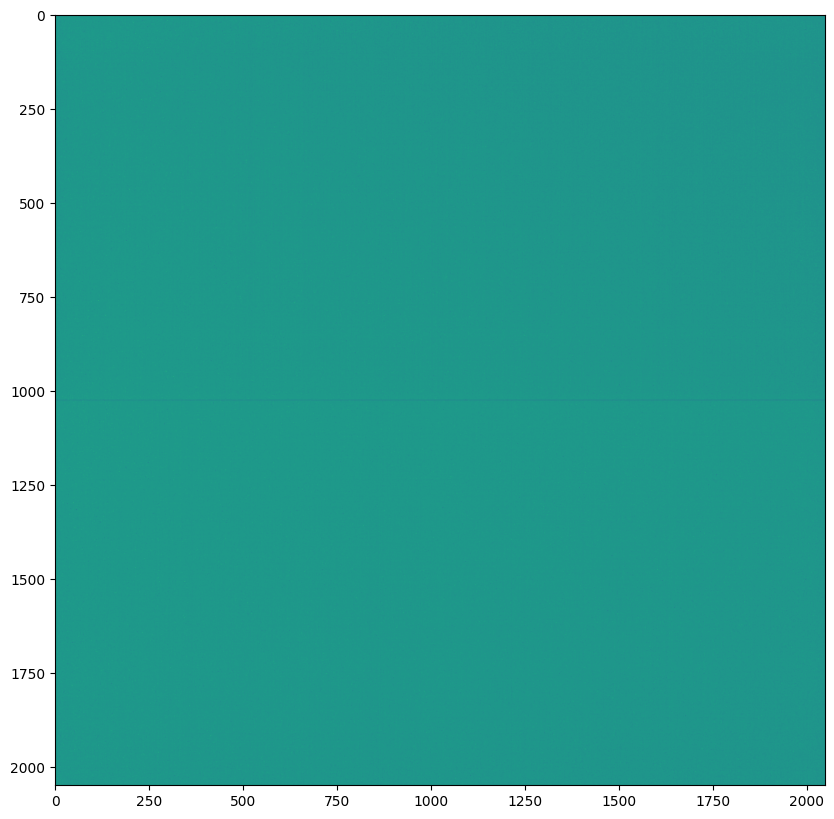

In [2]:
import math
import h5py
import numpy
from PIL import Image , ImageFilter
import csv
import matplotlib.pyplot as plt


def check_cam_file(filename: str, isDotH5: bool) -> bool:
    """
    Returns True if the given filename is a valid camera file, i.e., if it ends with '.lux.h5' and
    starts with either 'channel_base_name1' or 'channel_base_name2', and False otherwise.

    Args:
    - filename (str): The name of the file to be checked.
    - isDotH5 (bool): Flag to check if it's .h5 or .lux.h5

    Returns:
    - bool: True if the file is a valid camera file, False otherwise.
    """
    ext_str = '.lux.h5'
    if isDotH5:
        ext_str = '.h5'
    if filename.endswith(ext_str) and (filename.startswith(channel_base_name1) or filename.startswith(channel_base_name2)):
        return True
    return False


def get_all_h5(experiment_path:str, isDotH5: bool) -> list:
    """
    Returns a list of all the '.lux.h5' files in the given experiment path and its subdirectories.

    Args:
    - experiment_path (str): The path to the experiment directory.
    - isDotH5 (bool): Flag to check if it's .h5 or .lux.h5

    Returns:
    - list: A list of strings representing the paths to all the '.lux.h5' files in the given experiment path and
            its subdirectories.
    """
    result = [os.path.join(dp, f)
        for dp, dn, filenames in os.walk(experiment_path)
        for f in filenames if check_cam_file(f, isDotH5)]
    return result

all_H5s = get_all_h5(experiment_path, isDotH5)
print('Found total of {0} image files to process...'.format(len(all_H5s)))
currentH5 = all_H5s[0]
try:
    print('Trying to show: ', currentH5)
    fileIn2 = h5py.File(currentH5, 'r') #open current channel 2 H5 file in read mode.
except IOError:
    print('Failed to load file: ' + currentH5)
    print('Check that your path-to-file is correct.')
    print('Did you remember to include the top and bottom-most directories?')
    print('Are we .h5 or .lux.h5? Ensure that the parameter is set correctly:')
    print('True = .h5; False = .lux.h5')
    pass
fileAttributes = fileIn2[('/')]
fileAttributes = h5py.AttributeManager(fileAttributes)
dataset = fileIn2[('Data')]
dataAttributes = h5py.AttributeManager(dataset)
dataset = fileIn2[('Data')]
dataset = numpy.ascontiguousarray(dataset)
f = plt.figure(figsize = (10,10))
plt.imshow(dataset[ZtoDisplay,:,:])
   

# Step 3: Convert the H5 files to KLB

Run both the cells. This will take a while to run. Try to have fewer other programs things running on the computer.

**If you ran Step 3 before already, you can jump to step 4 with the same input paths.**

In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [ ]:
### Automated Script Begins for KLB Conversion ###
import pyklb # this is our .klb management package
import scipy # this imports all of science python. We'll probably use something from it. 
from scipy import ndimage
from joblib import Parallel, delayed

def PARKLBWrite(currentfilenum: int):
    """
    Writes a KLB file and produces a maximum intensity projection (MIP) of the file in PNG format.

    Args:
        currentfilenum (int): An integer representing the current file number.

    Returns:
        int: Returns 0 if the function is not able to load the current H5 file.

    Raises:
        None.
    """
    try:
        currentH51 = all_H5s[currentfilenum]
        fileIn1 = h5py.File(currentH51, 'r') #open current channel 1 H5 file in read mode.
        dataset1 = fileIn1["Data"][:]
    except:
        print('failed to load ' + currentH51)
        return 0
    
    klbBlobCH1 = numpy.ascontiguousarray(dataset1)
    
    dir_path = os.path.dirname(currentH51)
    filename = os.path.splitext(os.path.basename(currentH51))[0]
    out_dir_path = dir_path.replace(os.path.normpath(experiment_path), os.path.join(output_path, os.path.basename(experiment_path)))
    mip_dir_path = os.path.join(out_dir_path, 'MIPs')
    if not os.path.isdir(out_dir_path):
        try: 
            os.makedirs(out_dir_path)
            os.makedirs(mip_dir_path)
        except OSError:
            pass
    output_to_file = os.path.join(out_dir_path, filename+'.klb')
    MetaDataString1 = ''
    pyklb.writefull(numpy.ascontiguousarray(klbBlobCH1), output_to_file, numThreads, pixel_spacing, MetaDataString1)

    # Prodice the MIP in png format
    mip_to_file = os.path.join(mip_dir_path, 'MIP_' + filename + '.png')
    mipOut = numpy.amax(numpy.ascontiguousarray(klbBlobCH1),0)
    mipIMG = Image.fromarray(mipOut)
    mipIMG.save(mip_to_file)
    return 1

# Setup required parameters for KLB conversion 
zspace, yspace, xspace = dataAttributes[('element_size_um')]
cspace = 1
pixel_spacing = [timestep, cspace, zspace, yspace, xspace]
zmax , xmax , ymax = dataset.shape

out_experiment_path = os.path.join(output_path, os.path.basename(experiment_path))
print('Starting parallel conversion process. Output directory: ' + out_experiment_path)
# Initiate KLB conversion in parallel for all the H5 files
if foreground:
    numThreads= 10 #how many threads do you want pyklb to have access to during the write step
    results = Parallel(n_jobs=10, verbose = 50, backend = "threading")(map(delayed(PARKLBWrite),range(0,len(all_H5s))))
else:
    numThreads= 5 #how many threads do you want pyklb to have access to during the write step
    results = Parallel(n_jobs=2, verbose = 50, backend = "threading")(map(delayed(PARKLBWrite),range(0,len(all_H5s))))

with open(os.path.join(out_experiment_path,'parameterData.csv'), 'w') as csvfile:
    fieldnames = ['param', 'value']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    #px parameters
    writer.writerow({'param': '-', 'value' : '-'})
    writer.writerow({'param': 'timestep', 'value' : 'timestep'})
    writer.writerow({'param': 'z step', 'value': zspace})
    writer.writerow({'param': 'pixelSize', 'value': xspace})
    #timestep, cspace, zspace, yspace, xspace
import shutil
nb_full_path = os.path.join(os.getcwd(), nb_name)
shutil.copy2(nb_full_path , os.path.join(out_experiment_path , 'scriptUsed.ipynb'))
print('Initial KLB Conversion Task Complete!')

## Step 4: Merge the Stacks and Re-number KLBs

Check if you have correctly setup the `channel_jumps` parameter. 

**If you ran Step 4 successfully before, you can jump to step 5 with the same input paths. You can't however skip Step 4 even if you have one acquisition folder.**

In [ ]:
from distutils.dir_util import copy_tree
import shutil

# Initialized again so that this step could be run if Step 3 is being skipped 
out_experiment_path = os.path.join(output_path, os.path.basename(experiment_path))

def get_filename_components(image_file_str: str) -> list:
    """
    Extracts components from a filename string.

    Args:
        image_file_str (str): A string representing the filename of an image file.

    Returns:
        list: A list of three components extracted from the filename string, namely:
              - file_prefix: A string representing the prefix of the filename, obtained by removing the
                file extension and the time index.
              - file_ext: A string representing the file extension (fixed value of ".lux.klb").
              - time_index: An integer representing the time index extracted from the filename.

    Raises:
        None.
    """
    file_ext = ".lux.klb"
    file_base = image_file_str.replace(file_ext,'')
    file_tok_list = file_base.split('_')
    file_prefix = '_'.join(file_tok_list[0:-1])
    time_index = int(file_tok_list[-1])
    return file_prefix, file_ext, time_index

def file_timepoint_dict(dir_path: str)->dict:
    """
    Creates a dictionary mapping time indices to a list of files that have that time index.

    Args:
        dir_path (str): A string representing the path to a directory containing image files.

    Returns:
        dict: A dictionary where the keys are integers representing time indices, and the values are lists
              of strings representing filenames that have that time index.

    Raises:
        None.
    """
    time_file_dict = {}
    for fname in os.listdir(dir_path):
        f_path = os.path.join(dir_path,fname)
        if os.path.isfile(f_path):
            file_prefix, file_ext, time_index = get_filename_components(fname)
            if time_index in time_file_dict:
                time_file_dict[time_index].append(fname)
            else:
                time_file_dict[time_index] = [fname]
    return time_file_dict

def extract_channel_id(stack_dir_name) -> int:
    """
    Extracts the channel ID from a stack directory name.

    Args:
        stack_dir_name (str): A string representing the name of a stack directory.

    Returns:
        int: An integer representing the channel ID extracted from the stack directory name.

    Raises:
        ValueError: If the stack directory name is not in the correct format (i.e., does not contain the
                    string 'channel' followed by an integer).
    """

    stack_tok = stack_dir_name.split('_')
    try:
        return int(stack_tok[stack_tok.index('channel') + 1])
    except Exception as e:
        print(e)
        raise ValueError('Error! Stack directory not correct format{!r}'.format(stack_dir_name))

# Remove merged directories if there are any
merged_experiment_path = os.path.join(out_experiment_path, 'merged')
if os.path.isdir(merged_experiment_path):
    shutil.rmtree(merged_experiment_path)

run_dirs = next(os.walk(out_experiment_path))[1]
run_dict = {}
for run in run_dirs:
    run_dir_tok = run.split(sep='_')
    if len(run_dir_tok) == 2:
        rid_id = run_dir_tok[1]
        run_dict[rid_id] = run

# Sort the runs
sorted_runs = list(run_dict.keys())
sorted_runs.sort()

# Remove the first run dictionary
if len(run_dict) > 1 and SkipFirstSeries:
    run_dict.pop(sorted_runs[0])
    sorted_runs.pop(0)
    
# Create merging directory
if not os.path.isdir(merged_experiment_path):
    os.makedirs(merged_experiment_path)

# Loop over and merge if needed
for run in sorted_runs: 
    print('Merging stacks in run: ' + run_dict[run])
    run_dir = os.path.join(out_experiment_path, run_dict[run], 'raw')
    this_stack_dirs = next(os.walk(run_dir))[1]
    existing_stack_dirs = next(os.walk(merged_experiment_path))[1]
    for stack_dir in this_stack_dirs:
        # Get channel ID and jump
        channel_id = extract_channel_id(stack_dir)
        channel_jump = channel_jumps[channel_id]
        
        # Setup the stack directories 
        dest_dir_long = os.path.join(merged_experiment_path,stack_dir,'Long')
        dest_dir_long_mips = os.path.join(merged_experiment_path,stack_dir,'Long', 'MIPs')
        dest_dir_short = os.path.join(merged_experiment_path,stack_dir,'Short')
        dest_dir_short_mips = os.path.join(merged_experiment_path,stack_dir,'Short', 'MIPs')
        src_dict = os.path.join(run_dir,stack_dir)
        if not os.path.isdir(dest_dir_long):
            os.makedirs(dest_dir_long)
            os.makedirs(dest_dir_short)
            os.makedirs(dest_dir_long_mips)
            os.makedirs(dest_dir_short_mips)
            
        if stack_dir not in existing_stack_dirs: # If this stack is the first one, copy all the files
            src_dict = os.path.join(run_dir,stack_dir)
            for f in os.listdir(src_dict):
                f_path = os.path.join(src_dict,f)
                if os.path.isfile(f_path):
                    f_base = os.path.splitext(f)[0]
                    f_mip = os.path.join(src_dict, 'MIPs', 'MIP_' + f_base + '.png')
                    if 'Long' in f:
                        shutil.copy2(f_path, os.path.join(dest_dir_long,f))
                        shutil.copy2(f_mip, os.path.join(dest_dir_long_mips, 'MIP_' + f_base + '.png'))
                    else:
                        shutil.copy2(f_path, os.path.join(dest_dir_short,f))
                        shutil.copy2(f_mip, os.path.join(dest_dir_short_mips, 'MIP_' + f_base + '.png'))
        else:
            # Get the files indexed by the timepoints
            dest_files_dict = file_timepoint_dict(dest_dir_long)
            src_files_dict = file_timepoint_dict(src_dict)
            prev_timestamp = sorted(dest_files_dict.keys())[-1]
            for time_idx, fname_list in src_files_dict.items():
                for fname in fname_list:
                    f_base = os.path.splitext(fname)[0]
                    file_prefix, file_ext, time_index = get_filename_components(fname)
                    f_mip_name = 'MIP_' + f_base + '.png'
                    new_time_index = f'{(prev_timestamp + channel_jump + time_index):05}'
                    new_file_name = file_prefix + '_' + new_time_index + file_ext
                    new_mip_file_name = 'MIP_' + file_prefix + '_' + new_time_index + '.png'
                    if 'Long' in fname:
                        shutil.copy2(os.path.join(src_dict, fname), os.path.join(dest_dir_long, new_file_name))
                        shutil.copy2(os.path.join(src_dict, 'MIPs', f_mip_name), 
                                     os.path.join(dest_dir_long_mips, new_mip_file_name))
                    else:
                        shutil.copy2(os.path.join(src_dict, fname), os.path.join(dest_dir_short, new_file_name))
                        shutil.copy2(os.path.join(src_dict, 'MIPs', f_mip_name), 
                                     os.path.join(dest_dir_short_mips, new_mip_file_name))
                        
print('Merging the stacks is complete!')
print('Merged files are here: ' + merged_experiment_path)

print('Deleting the acqusition stack:')
for run in run_dirs:
    run_dir = os.path.join(out_experiment_path, run)
    shutil.rmtree(run_dir)

## Step 5: Crop the KLB Files 

In [3]:
from roi_convertor.gen_crops import *
import shutil

def group_stack_dir(stack_dirs: list[str]) -> dict: 
    """
    Groups stack directory names by their stack ID.

    Args:
        stack_dirs (list[str]): A list of stack directory names.

    Returns:
        dict: A dictionary where the keys are the stack IDs (as integers), and the values are lists of
              directory names that correspond to that stack ID.

    Raises:
        None.
    """
    stack_dict = {}
    for stack_dir_name in stack_dirs:
        stack_dir_tok = stack_dir_name.split(sep='_')
        if len(stack_dir_tok) > 2 and stack_dir_tok[0] == 'stack':
            stack_id = int(stack_dir_tok[1])
            if stack_id not in stack_dict: 
                stack_dict[stack_id] = [stack_dir_name]
            else:
                stack_dict[stack_id].append(stack_dir_name)
    return stack_dict
    
# Initialized again so that this step could be run if Step 3/4 is being skipped 
out_experiment_path = os.path.join(output_path, os.path.basename(experiment_path))
merged_experiment_path = os.path.join(out_experiment_path, 'merged')

# Remove cropped directories if there are any
cropped_experiment_path = os.path.join(out_experiment_path, 'cropped')
if os.path.isdir(cropped_experiment_path):
    shutil.rmtree(cropped_experiment_path)

# Create cropped directory
os.makedirs(cropped_experiment_path)

stack_dirs = next(os.walk(merged_experiment_path))[1]

stack_dict = group_stack_dir(stack_dirs)

stack_crop_dir = {}
stack_crop_found = {}
for stack_id, channel_dirs in stack_dict.items():
    for stack_dir_name in channel_dirs:
        cam_type = 'Long'
        stack_dir = os.path.join(merged_experiment_path, stack_dir_name, cam_type)
        cropbox_path = os.path.join(cropped_experiment_path, 'stack_' + str(stack_id) + '_cropboxes')
        
        # Create cropbox directory
        if not os.path.isdir(cropbox_path):
            os.makedirs(cropbox_path)
        
        # Generate the cropboxes
        box_count = gen_cropboxes(stack_dir, cropbox_path)
        
        # If there is only one box, we can assume the cropping was success
        # Save the cropbox and move to the next stack
        if box_count == 1:
            stack_crop_found[stack_id] = stack_dir
            stack_crop_dir[stack_id] = cropbox_path
            break
        else:
            shutil.rmtree(cropbox_path)

# Print the crop boxes to be used
for stack_id, stack_dir in stack_crop_dir.items():
    print('Stack ' + str(stack_id) + ' to be cropped using boxes of: ' + stack_dir)
    
            
# Crop all the stack directories using the cropboxes for each stack
for stack_id, channel_dirs in stack_dict.items():
    for stack_dir_name in channel_dirs:
        for cam_type in ['Long', 'Short']:
            stack_dir = os.path.join(merged_experiment_path, stack_dir_name, cam_type)
            cropped_image_path = os.path.join(cropped_experiment_path, stack_dir_name+'_cropped', cam_type)
            mip_image_path = os.path.join(cropped_experiment_path, stack_dir_name+'_mip', cam_type)
            # Create cropped image directory
            if not os.path.isdir(cropped_image_path):
                os.makedirs(cropped_image_path)
                os.makedirs(mip_image_path)
            
            
            if stack_id in stack_crop_dir:
                # If cropbox was identified for the stack
                # Generate the cropped files
                cropbox_path = stack_crop_dir[stack_id]
                generate_crops(stack_dir, cropbox_path, cropped_image_path, 0, 0, -1, 150, 1, 1, 'klb', False)
                visualize_cropboxes(stack_dir, cropbox_path, mip_image_path, 0, 0, -1, 150)
            else:
                # If cropbox was NOT identified for the stack
                # Copy over the files
                for f in os.listdir(stack_dir):
                    f_path = os.path.join(stack_dir,f)
                    if os.path.isfile(f_path):
                        shutil.copy2(f_path, os.path.join(cropbox_path,f))
                
print(' ')
print(' ')
print('Finished Processing Experiment:' + experiment_path)
print('Processing Files:' + out_experiment_path)
print(' ')
print(' ')
print('Script Finished!')

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00000.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00001.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00002.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00003.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00004.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00048.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00049.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00050.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00051.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00052.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00009.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00010.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00011.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00012.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00013.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00057.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00058.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00059.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00060.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00061.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00017.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00018.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00019.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00020.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00021.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00065.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00066.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00067.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00068.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00069.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00026.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00027.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00028.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00029.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00030.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00074.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00075.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00076.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00077.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Long\Cam_Long_00078.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00035.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00036.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00037.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00038.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00039.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00083.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00084.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00085.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00086.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00000.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00044.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00045.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00046.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00047.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_obj_left\Short\Cam_Short_00048.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_0_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00005.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00006.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00007.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00008.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00009.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00053.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00054.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00055.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00056.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00057.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00014.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00015.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00016.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00017.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00018.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00062.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00063.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00064.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00065.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Long\Cam_Long_00066.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00023.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00024.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00025.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00026.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00027.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00071.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00072.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00073.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00074.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00075.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00032.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00033.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00034.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00035.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00036.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00080.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00081.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00082.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00083.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_obj_left\Short\Cam_Short_00084.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_1_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00041.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00042.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00043.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00044.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00045.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00002.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00003.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00004.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00005.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00006.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00050.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00051.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00052.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00053.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Long\Cam_Long_00054.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00011.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00012.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00013.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00014.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00015.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00059.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00060.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00061.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00062.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00063.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00020.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00021.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00022.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00023.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00024.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00068.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00069.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00070.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00071.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_obj_left\Short\Cam_Short_00072.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_1_channel_2_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00029.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00030.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00031.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00032.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00033.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00077.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00078.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00079.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00080.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00081.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00038.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00039.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00040.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00041.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00042.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Long\Cam_Long_00086.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00000.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00001.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00002.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00003.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00047.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00048.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00049.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00050.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00051.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00008.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00009.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00010.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00011.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00012.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00056.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00057.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00058.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00059.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_obj_left\Short\Cam_Short_00060.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_0_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00017.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00018.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00019.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00020.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00021.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00065.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00066.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00067.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00068.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00069.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00026.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00027.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00028.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00029.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00030.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00074.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00075.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00076.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00077.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Long\Cam_Long_00078.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00035.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00036.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00037.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00038.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00039.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00083.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00084.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00085.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00086.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00000.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00044.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00045.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00046.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00047.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_obj_left\Short\Cam_Short_00048.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_1_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00005.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00006.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00007.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00008.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00009.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00053.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00054.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00055.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00056.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00057.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00014.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00015.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00016.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00017.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00018.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00062.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00063.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00064.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00065.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Long\Cam_Long_00066.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Lo

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00023.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00024.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00025.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00026.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00027.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00071.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00072.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00073.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00074.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00075.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00032.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00033.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00034.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00035.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00036.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_o

loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00080.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00081.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00082.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00083.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_obj_left\Short\Cam_Short_00084.lux.klb
loaded image shape: (56, 2048, 2048)
Processing: Z:\Abhishek\processed\230119_YAP_Sox2_memb-GFP_H2B-miRFP720\merged\stack_2_channel_2_o

The following cells are intended for debugging